# Advanced Pipelines with scikit-learn
https://towardsdatascience.com/advanced-pipelines-with-scikit-learn-4204bb71019b

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, 
                                     RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

# Handle constant/duplicates and missing features/columns
from feature_engine.selection import (DropFeatures, DropConstantFeatures, 
                                      DropDuplicateFeatures)
# Sampling
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

from tqdm import tqdm
from sklearn import set_config
set_config(display="diagram") # make pipeline visible

import warnings
warnings.filterwarnings('ignore')

In [12]:
DATA_DIR = '/Users/andishetavakkoli/Documents/notebook/github_project/machine-learning-projects-data/anomaly_detection'

In [13]:
df = pd.read_csv(DATA_DIR + '/creditcard.csv')

In [14]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
df.columns = [k.lower().replace(" ", "_") for k in df.columns]

# Step 1: cleaning data

In [16]:
df[df.duplicated(keep=False) == True]

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284190,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284192,172233.0,-2.691642,3.123168,-3.339407,1.017018,-0.293095,-0.167054,-0.745886,2.325616,-1.634651,...,0.402639,0.259746,-0.086606,-0.097597,0.083693,-0.453584,-1.205466,-0.213020,36.74,0


In [17]:
df.drop_duplicates(inplace=True)

In [18]:
inlier_df = df[df['class'] == 0].sample(5000)
outlier_df = df[df['class'] == 1].sample(50)
concat_df = pd.concat([inlier_df, outlier_df], axis=0)

In [19]:
X = concat_df.drop(['class'], axis=1)
y = concat_df[['class']]

# Split X, y train , test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Balance the data

In [64]:
sm = SMOTE()
X_resample, y_resample = sm.fit_resample(X_train, y_train)

# Define Bias and variance 

In [67]:
dt = DecisionTreeClassifier(random_state=1)
score_CV = cross_val_score(dt, X_resample, y_resample, cv=10, scoring='f1')

dt.fit(X_resample, y_resample)
y_pred_train = dt.predict(X_resample)
y_pred_test = dt.predict(X_test)

In [68]:
# CV score
print('CV score_CV: {:.2f}'.format(score_CV.mean()))

CV score_CV: 1.00


In [69]:
# Training set f1 score
print('Train score_CV: {:.2f}'.format(f1_score(y_resample, y_pred_train)))

Train score_CV: 1.00


In [70]:
# Training set f1 score
print('Train score_CV: {:.2f}'.format(f1_score(y_test, y_pred_test)))

Train score_CV: 0.86


### This data is overfitting, so we can apply Bagging classifier or randomforest algorithem

In [117]:
bc = BaggingClassifier(base_estimator=dt, n_estimators=20, oob_score=True, random_state=1)
score_CV = cross_val_score(bc, X_resample, y_resample, cv=10, scoring='f1')
bc.fit(X_resample, y_resample)
y_pred_train = bc.predict(X_resample)
y_pred_test = bc.predict(X_test)

In [124]:
print(f'Test accuracy score: {accuracy_score(y_test, y_pred_test)}')

Test accuracy score: 1.0


In [118]:
# CV score
print('CV score_CV: {:.2f}'.format(score_CV.mean()))

CV score_CV: 1.00


In [119]:
# Training set f1 score
print('Train score_CV: {:.2f}'.format(f1_score(y_resample, y_pred_train)))

Train score_CV: 1.00


In [120]:
f_score = f1_score(y_test, y_pred_test)
print('f1 score of bagging classifier: {:.3f}'.format(f_score))

f1 score of bagging classifier: 1.000


In [121]:
bc.oob_score_

0.998125

# RandomForest

In [106]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
score_CV = cross_val_score(bc, X_resample, y_resample, cv=10, scoring='f1')
rf.fit(X_resample, y_resample)
y_pred_train = rf.predict(X_resample)
y_pred_test = rf.predict(X_test)

In [107]:
# CV score
print('CV score_CV: {:.2f}'.format(score_CV.mean()))

CV score_CV: 1.00


In [108]:
# Training set f1 score
print('Train score_CV: {:.2f}'.format(f1_score(y_resample, y_pred_train)))

Train score_CV: 1.00


In [109]:
f_score = f1_score(y_test, y_pred_test)
print('f1 score of bagging classifier: {:.3f}'.format(f_score))

f1 score of bagging classifier: 1.000


# Feature Importance in sklearn

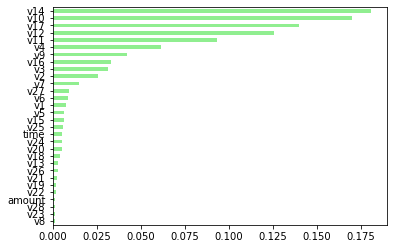

In [110]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen'); 
plt.show()

# Step 2: Exclude features, Sampling

# Step 4: Building the ensemble classifier

In [11]:
lr = LogisticRegression(warm_start= True, max_iter=40)
rf = RandomForestClassifier()
xgb = XGBClassifier(tree_method="hist", verbosity=0, silent=True)

lr_xgb_rf = VotingClassifier(estimators=[('lr', lr), ('xgb', xgb), ('rf', rf)], 
                             voting='soft')

In [12]:
ppl = imbPipeline([
    ('drop_duplicates', DropDuplicateFeatures()), 
    ('cleaning', ColumnTransformer([
        ('num',make_pipeline(
        SimpleImputer(),
        MinMaxScaler(), 
            ), X.columns   
        )     
        
    ])), ('smote', SMOTE()),
    ('ensemble', lr_xgb_rf)
    
])

In [13]:
ppl.fit(X_train, y_train)

Pipeline(steps=[('drop_duplicates', DropDuplicateFeatures()),
                ('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25',...
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)),
                                              ('rf', RandomForestClassifier())],
                                  voting='soft'))])

# Step 5: Hyperparameter tuning and feature importance

In [ ]:
RandomForestClassifier(max_depth=10,
                                                                      min_samples_leaf=4,
                                                                      min_samples_split=5,
                                                                      n_estimators=600)

In [14]:
# Hyperparameter Tuning

params = params = {
    'ensemble__lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'ensemble__lr__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'ensemble__lr__C': loguniform(1e-5, 100),
    'ensemble__xgb__learning_rate': [0.1],
    'ensemble__xgb__max_depth': [7, 10, 15, 20],
    'ensemble__xgb__min_child_weight': [10, 15, 20, 25],
    'ensemble__xgb__colsample_bytree': [0.8, 0.9, 1],
    'ensemble__xgb__n_estimators': [300, 400, 500, 600],
    'ensemble__xgb__reg_alpha': [0.5, 0.2, 1],
    'ensemble__xgb__reg_lambda': [2, 3, 5],
    'ensemble__xgb__gamma': [1, 2, 3],
    'ensemble__rf__max_depth': [7, 10, 15, 20],
    'ensemble__rf__min_samples_leaf': [1, 2, 4],
    'ensemble__rf__min_samples_split': [2, 5, 10],
    'ensemble__rf__n_estimators': [300, 400, 500, 600],
}

In [15]:
rsf = RepeatedStratifiedKFold(random_state=42)
clf = RandomizedSearchCV(ppl, params, scoring='f1', cv=rsf)

In [16]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('drop_duplicates',
                                              DropDuplicateFeatures()),
                                             ('cleaning',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9'...
                                        'ensemble__rf__n_estimators': [300, 400,
                                                                       500,
                                                                       600],
                                        'ensemble__xgb__colsample_bytree': [0.8,
                                                                            0.9,
                                                                            1],
                                        'ensemble__xgb__gamma': [1, 2, 3],
                                        'ensemble__xgb__learning_rate': [0.1],
                                        'ensemble__xgb__max_depth': [7, 10, 15,
                                                                     20],
                                        'ensemble__xgb__min_child_weight': [10,
                                                                            15,
                                                                            20,
                                                                            25],
                                        'ensemble__xgb__n_estimators': [300,
                                                                        400,
                                                                        500,
                                                                        600],
                                        'ensemble__xgb__reg_alpha': [0.5, 0.2,
                                                                     1],
                                        'ensemble__xgb__reg_lambda': [2, 3, 5]},
                   scoring='f1')

In [19]:
print('Best Score', clf.best_score_)
print('Best Params', clf.best_estimator_)
print('AUC:', roc_auc_score(y_test, clf.predict(X_test)))

Best Score 0.6755122944419214
Best Params Pipeline(steps=[('drop_duplicates', DropDuplicateFeatures()),
                ('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25',...
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                      

In [ ]:
best_model = clf.best_prams_.predict(X_test)

In [136]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
X = np.array([[7, 2, 6], [3, 4, 8], [3, 4, 8],[6, 2, 9], [3, 4, 1]])
y = np.array([5, 5, 0, 0, 2])
rskf = StratifiedKFold(n_splits=5,random_state=36851234, shuffle=True)


In [134]:
for i, (train_index, test_index) in enumerate(rskf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [137]:
list(rskf.split(X, y))

[(array([1, 2]), array([0, 3, 4])), (array([0, 3, 4]), array([1, 2]))]

In [123]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
X = np.array([[7, 2, 6], [3, 4, 8], [3, 4, 8],[6, 2, 9], [3, 4, 1]])
y = np.array([5, 5, 0, 0, 2])
rskf = RepeatedStratifiedKFold(n_splits=2,
                               random_state=36851234)


In [124]:
for i, (train_index, test_index) in enumerate(rskf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
   

Fold 0:
  Train: index=[1 2]
  Test:  index=[0 3 4]
Fold 1:
  Train: index=[0 3 4]
  Test:  index=[1 2]
Fold 2:
  Train: index=[1 3]
  Test:  index=[0 2 4]
Fold 3:
  Train: index=[0 2 4]
  Test:  index=[1 3]
Fold 4:
  Train: index=[1 2]
  Test:  index=[0 3 4]
Fold 5:
  Train: index=[0 3 4]
  Test:  index=[1 2]
Fold 6:
  Train: index=[0 3]
  Test:  index=[1 2 4]
Fold 7:
  Train: index=[1 2 4]
  Test:  index=[0 3]
Fold 8:
  Train: index=[1 3]
  Test:  index=[0 2 4]
Fold 9:
  Train: index=[0 2 4]
  Test:  index=[1 3]
Fold 10:
  Train: index=[0 3]
  Test:  index=[1 2 4]
Fold 11:
  Train: index=[1 2 4]
  Test:  index=[0 3]
Fold 12:
  Train: index=[0 2]
  Test:  index=[1 3 4]
Fold 13:
  Train: index=[1 3 4]
  Test:  index=[0 2]
Fold 14:
  Train: index=[0 3]
  Test:  index=[1 2 4]
Fold 15:
  Train: index=[1 2 4]
  Test:  index=[0 3]
Fold 16:
  Train: index=[0 3]
  Test:  index=[1 2 4]
Fold 17:
  Train: index=[1 2 4]
  Test:  index=[0 3]
Fold 18:
  Train: index=[1 3]
  Test:  index=[0 2 4]
Fol

In [101]:
y

array([5, 5, 0, 0])

In [102]:
list(rskf.split(X, y))

[(array([1, 2]), array([0, 3])),
 (array([0, 3]), array([1, 2])),
 (array([1, 3]), array([0, 2])),
 (array([0, 2]), array([1, 3])),
 (array([1, 2]), array([0, 3])),
 (array([0, 3]), array([1, 2])),
 (array([0, 3]), array([1, 2])),
 (array([1, 2]), array([0, 3])),
 (array([1, 3]), array([0, 2])),
 (array([0, 2]), array([1, 3])),
 (array([0, 3]), array([1, 2])),
 (array([1, 2]), array([0, 3])),
 (array([0, 2]), array([1, 3])),
 (array([1, 3]), array([0, 2])),
 (array([0, 3]), array([1, 2])),
 (array([1, 2]), array([0, 3])),
 (array([0, 3]), array([1, 2])),
 (array([1, 2]), array([0, 3])),
 (array([1, 3]), array([0, 2])),
 (array([0, 2]), array([1, 3]))]